In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### 1. Accuracy - Loss

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.37, Prune Accuracy: 97.92, Sparsity: 66.80
Epoch: 20. Test Accuracy: 98.31, Prune Accuracy: 94.94, Sparsity: 96.41
Epoch: 30. Test Accuracy: 97.90, Prune Accuracy: 97.46, Sparsity: 97.02
Epoch: 40. Test Accuracy: 98.12, Prune Accuracy: 97.56, Sparsity: 97.02
Epoch: 50. Test Accuracy: 98.09, Prune Accuracy: 97.75, Sparsity: 97.02
Retrain Test: 98.09, Prune Test: 97.75, Prune Sparsity: 97.02


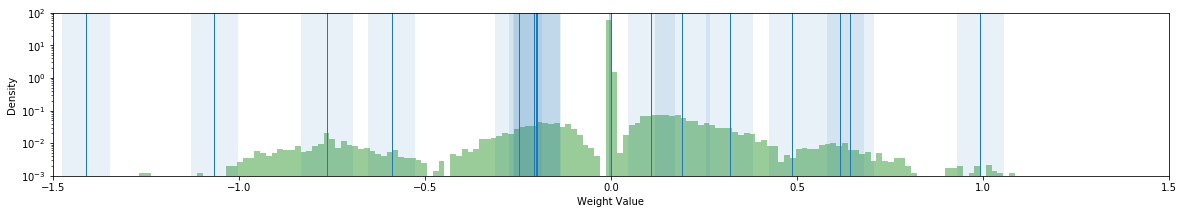

In [9]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### 2. Gamma Prior Variance

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.44, Prune Accuracy: 98.35, Sparsity: 58.61
Epoch: 20. Test Accuracy: 98.44, Prune Accuracy: 98.34, Sparsity: 66.71
Epoch: 30. Test Accuracy: 98.44, Prune Accuracy: 98.31, Sparsity: 72.00
Epoch: 40. Test Accuracy: 98.44, Prune Accuracy: 98.17, Sparsity: 75.89
Epoch: 50. Test Accuracy: 98.46, Prune Accuracy: 98.11, Sparsity: 78.85
Retrain Test: 98.46, Prune Test: 98.11, Prune Sparsity: 78.85


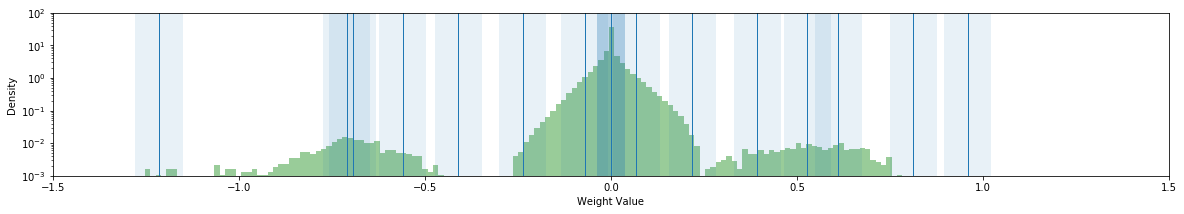

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 1.0
Epoch: 10. Test Accuracy: 98.42, Prune Accuracy: 98.39, Sparsity: 58.60
Epoch: 20. Test Accuracy: 98.54, Prune Accuracy: 98.38, Sparsity: 66.69
Epoch: 30. Test Accuracy: 98.50, Prune Accuracy: 98.31, Sparsity: 72.06
Epoch: 40. Test Accuracy: 98.46, Prune Accuracy: 98.14, Sparsity: 75.86
Epoch: 50. Test Accuracy: 98.48, Prune Accuracy: 98.14, Sparsity: 78.88
Retrain Test: 98.48, Prune Test: 98.14, Prune Sparsity: 78.88


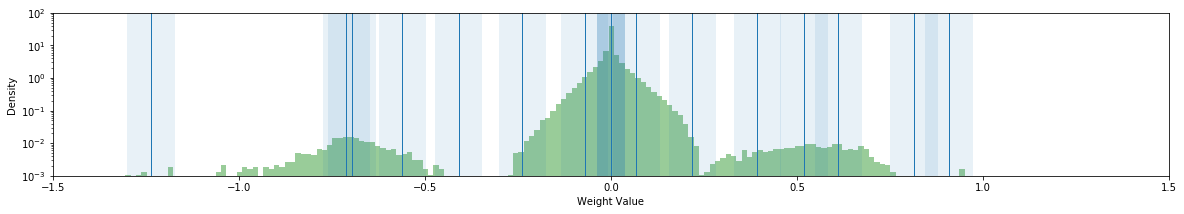

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.43, Prune Accuracy: 98.30, Sparsity: 58.65
Epoch: 20. Test Accuracy: 98.47, Prune Accuracy: 98.46, Sparsity: 66.72
Epoch: 30. Test Accuracy: 98.48, Prune Accuracy: 98.29, Sparsity: 72.10
Epoch: 40. Test Accuracy: 98.43, Prune Accuracy: 98.12, Sparsity: 76.49
Epoch: 50. Test Accuracy: 98.42, Prune Accuracy: 98.15, Sparsity: 79.74
Retrain Test: 98.42, Prune Test: 98.15, Prune Sparsity: 79.74


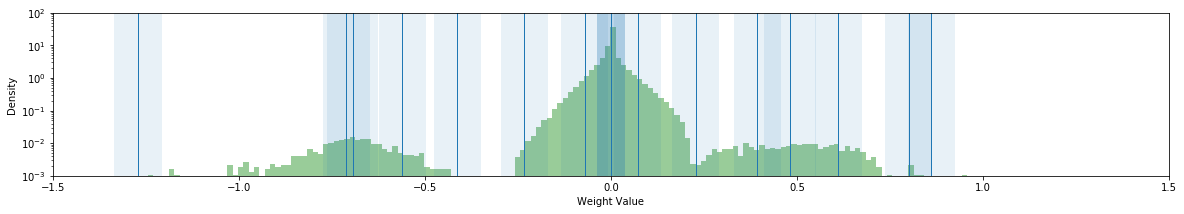

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 100.0
Epoch: 10. Test Accuracy: 98.41, Prune Accuracy: 98.26, Sparsity: 58.74
Epoch: 20. Test Accuracy: 98.45, Prune Accuracy: 98.38, Sparsity: 68.06
Epoch: 30. Test Accuracy: 98.49, Prune Accuracy: 98.22, Sparsity: 75.14
Epoch: 40. Test Accuracy: 98.47, Prune Accuracy: 98.10, Sparsity: 76.20
Epoch: 50. Test Accuracy: 98.39, Prune Accuracy: 97.77, Sparsity: 75.54
Retrain Test: 98.39, Prune Test: 97.77, Prune Sparsity: 75.54


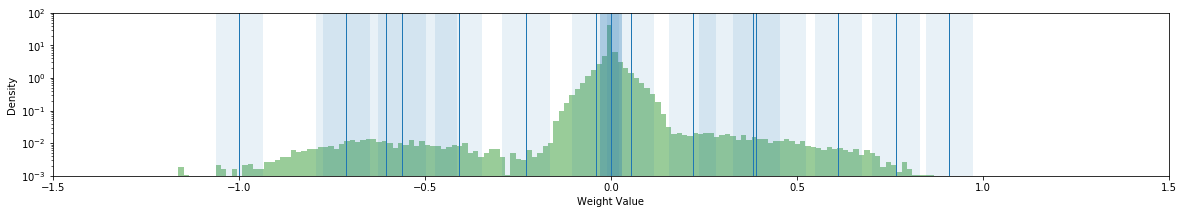

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 1000.0
Epoch: 10. Test Accuracy: 98.44, Prune Accuracy: 98.30, Sparsity: 58.82
Epoch: 20. Test Accuracy: 98.50, Prune Accuracy: 98.21, Sparsity: 66.18
Epoch: 30. Test Accuracy: 98.49, Prune Accuracy: 98.03, Sparsity: 68.93
Epoch: 40. Test Accuracy: 98.45, Prune Accuracy: 97.70, Sparsity: 71.95
Epoch: 50. Test Accuracy: 98.45, Prune Accuracy: 97.33, Sparsity: 73.51
Retrain Test: 98.45, Prune Test: 97.33, Prune Sparsity: 73.51


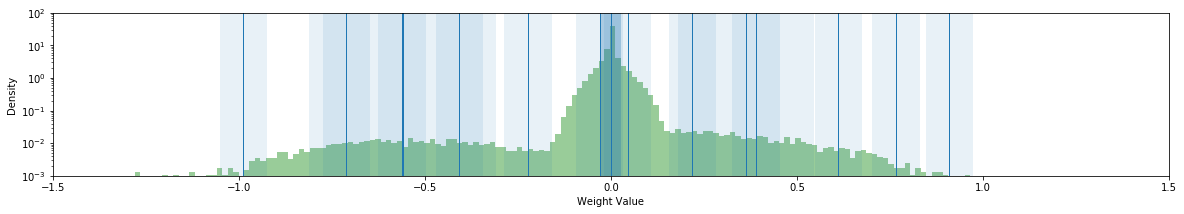

In [12]:
vlist = [0.1, 1, 10, 100, 1000]
zvar = 1250
for var in vlist:
    fn_text = "_var_{}_zvar_{}".format(var,zvar)
    model, gmp, res = retrain_model(250, var, 2500, zvar, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files", fn = fn_text)
    show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 5000.0
Non-zero component Mean: 250.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.46, Prune Accuracy: 97.92, Sparsity: 66.10
Epoch: 20. Test Accuracy: 98.22, Prune Accuracy: 95.68, Sparsity: 82.53
Epoch: 30. Test Accuracy: 98.07, Prune Accuracy: 96.26, Sparsity: 96.41
Epoch: 40. Test Accuracy: 98.23, Prune Accuracy: 97.70, Sparsity: 96.23
Epoch: 50. Test Accuracy: 98.14, Prune Accuracy: 97.90, Sparsity: 96.24
Retrain Test: 98.14, Prune Test: 97.90, Prune Sparsity: 96.24


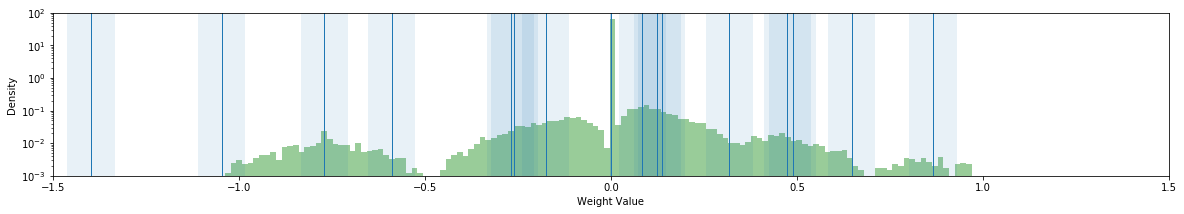

In [4]:
zvlist = [0.1, 1, 10, 100, 1000, 5000]
var = 0.1
for zvar in zvlist:
    fn_text = "_var_{}_zvar_{}".format(var,zvar)
    model, gmp, res = retrain_model(250, var, 2500, zvar, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files", fn = fn_text)
    show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### 3. Means

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 10.0 Variance: 1000.0
Non-zero component Mean: 0.1 Variance: 0.1
Epoch: 10. Test Accuracy: 98.34, Prune Accuracy: 97.90, Sparsity: 77.11
Epoch: 20. Test Accuracy: 97.97, Prune Accuracy: 97.44, Sparsity: 95.02
Epoch: 30. Test Accuracy: 98.30, Prune Accuracy: 97.82, Sparsity: 94.39
Epoch: 40. Test Accuracy: 98.32, Prune Accuracy: 98.17, Sparsity: 94.48
Epoch: 50. Test Accuracy: 98.38, Prune Accuracy: 98.13, Sparsity: 94.60
Retrain Test: 98.38, Prune Test: 98.13, Prune Sparsity: 94.60


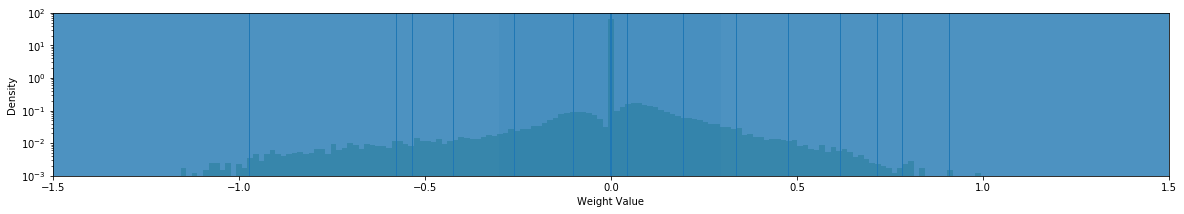

0-component Mean: 100.0 Variance: 999.9999999999998
Non-zero component Mean: 0.1 Variance: 0.1
Epoch: 10. Test Accuracy: 98.38, Prune Accuracy: 97.97, Sparsity: 77.07
Epoch: 20. Test Accuracy: 97.93, Prune Accuracy: 97.54, Sparsity: 95.17
Epoch: 30. Test Accuracy: 98.23, Prune Accuracy: 97.87, Sparsity: 94.60
Epoch: 40. Test Accuracy: 98.34, Prune Accuracy: 97.95, Sparsity: 94.34
Epoch: 50. Test Accuracy: 98.36, Prune Accuracy: 97.86, Sparsity: 94.77
Retrain Test: 98.36, Prune Test: 97.86, Prune Sparsity: 94.77


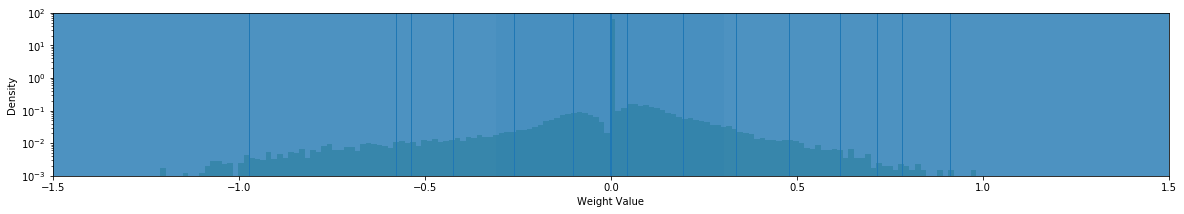

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 0.1 Variance: 0.1
Epoch: 10. Test Accuracy: 98.41, Prune Accuracy: 97.98, Sparsity: 77.11
Epoch: 20. Test Accuracy: 97.79, Prune Accuracy: 97.07, Sparsity: 96.00
Epoch: 30. Test Accuracy: 98.11, Prune Accuracy: 97.67, Sparsity: 95.85
Epoch: 40. Test Accuracy: 98.25, Prune Accuracy: 97.88, Sparsity: 95.04
Epoch: 50. Test Accuracy: 98.24, Prune Accuracy: 97.84, Sparsity: 95.49
Retrain Test: 98.24, Prune Test: 97.84, Prune Sparsity: 95.49


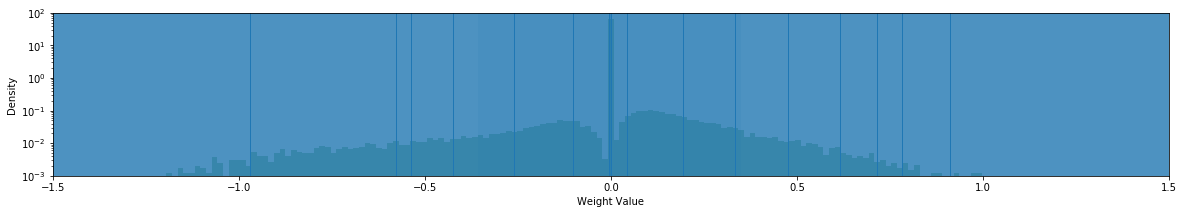

0-component Mean: 10.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.43, Prune Accuracy: 98.08, Sparsity: 78.15
Epoch: 20. Test Accuracy: 97.94, Prune Accuracy: 97.64, Sparsity: 95.10
Epoch: 30. Test Accuracy: 98.22, Prune Accuracy: 97.78, Sparsity: 94.42
Epoch: 40. Test Accuracy: 98.32, Prune Accuracy: 97.91, Sparsity: 94.50
Epoch: 50. Test Accuracy: 98.24, Prune Accuracy: 97.87, Sparsity: 94.62
Retrain Test: 98.24, Prune Test: 97.87, Prune Sparsity: 94.62


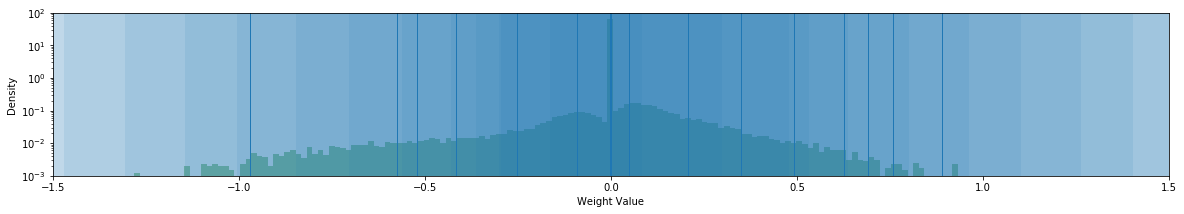

0-component Mean: 100.0 Variance: 999.9999999999998
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.38, Prune Accuracy: 98.10, Sparsity: 78.18
Epoch: 20. Test Accuracy: 97.95, Prune Accuracy: 97.69, Sparsity: 95.23
Epoch: 30. Test Accuracy: 98.22, Prune Accuracy: 97.79, Sparsity: 94.69
Epoch: 40. Test Accuracy: 98.35, Prune Accuracy: 97.85, Sparsity: 94.72
Epoch: 50. Test Accuracy: 98.29, Prune Accuracy: 97.91, Sparsity: 94.83
Retrain Test: 98.29, Prune Test: 97.91, Prune Sparsity: 94.83


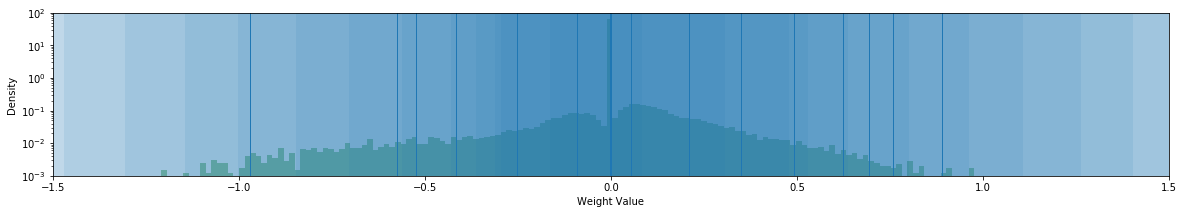

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.43, Prune Accuracy: 98.02, Sparsity: 78.27
Epoch: 20. Test Accuracy: 97.86, Prune Accuracy: 97.20, Sparsity: 95.98
Epoch: 30. Test Accuracy: 98.08, Prune Accuracy: 97.79, Sparsity: 95.86
Epoch: 40. Test Accuracy: 98.25, Prune Accuracy: 97.96, Sparsity: 95.64
Epoch: 50. Test Accuracy: 98.30, Prune Accuracy: 97.94, Sparsity: 95.86
Retrain Test: 98.30, Prune Test: 97.94, Prune Sparsity: 95.86


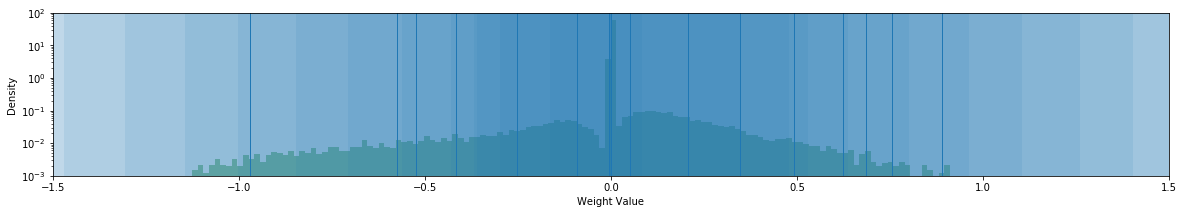

0-component Mean: 10.0 Variance: 1000.0
Non-zero component Mean: 10.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.32, Prune Accuracy: 97.48, Sparsity: 77.41
Epoch: 20. Test Accuracy: 98.02, Prune Accuracy: 97.58, Sparsity: 95.05
Epoch: 30. Test Accuracy: 98.31, Prune Accuracy: 97.20, Sparsity: 94.24
Epoch: 40. Test Accuracy: 98.36, Prune Accuracy: 97.38, Sparsity: 57.89
Epoch: 50. Test Accuracy: 98.31, Prune Accuracy: 97.42, Sparsity: 69.27
Retrain Test: 98.31, Prune Test: 97.42, Prune Sparsity: 69.27


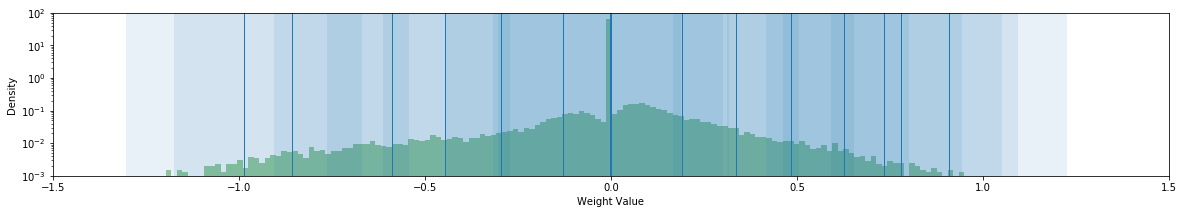

0-component Mean: 100.0 Variance: 999.9999999999998
Non-zero component Mean: 10.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.40, Prune Accuracy: 97.64, Sparsity: 77.53
Epoch: 20. Test Accuracy: 97.97, Prune Accuracy: 97.49, Sparsity: 95.12
Epoch: 30. Test Accuracy: 98.34, Prune Accuracy: 97.55, Sparsity: 94.43
Epoch: 40. Test Accuracy: 98.41, Prune Accuracy: 97.82, Sparsity: 93.65
Epoch: 50. Test Accuracy: 98.40, Prune Accuracy: 97.91, Sparsity: 94.46
Retrain Test: 98.40, Prune Test: 97.91, Prune Sparsity: 94.46


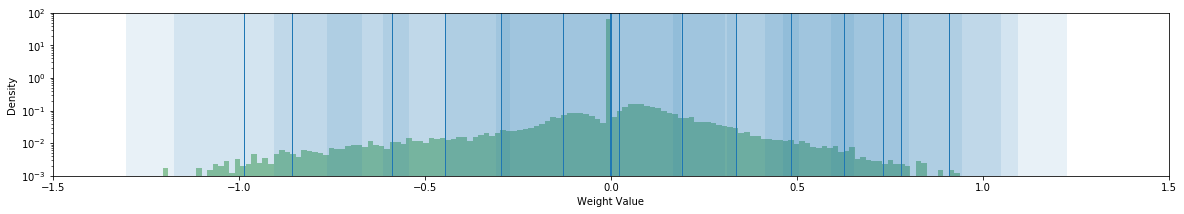

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 10.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.37, Prune Accuracy: 97.60, Sparsity: 77.77
Epoch: 20. Test Accuracy: 97.86, Prune Accuracy: 97.40, Sparsity: 95.99
Epoch: 30. Test Accuracy: 98.20, Prune Accuracy: 97.83, Sparsity: 95.77
Epoch: 40. Test Accuracy: 98.23, Prune Accuracy: 97.86, Sparsity: 93.90
Epoch: 50. Test Accuracy: 98.24, Prune Accuracy: 97.98, Sparsity: 94.89
Retrain Test: 98.24, Prune Test: 97.98, Prune Sparsity: 94.89


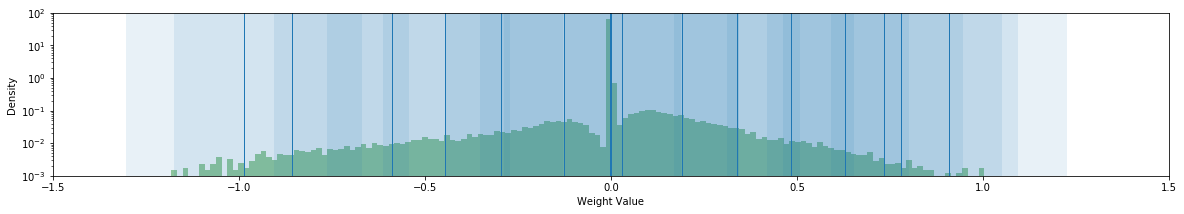

0-component Mean: 10.0 Variance: 1000.0
Non-zero component Mean: 100.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.40, Prune Accuracy: 98.01, Sparsity: 65.33
Epoch: 20. Test Accuracy: 98.14, Prune Accuracy: 95.79, Sparsity: 83.81
Epoch: 30. Test Accuracy: 98.24, Prune Accuracy: 97.98, Sparsity: 63.13
Epoch: 40. Test Accuracy: 98.30, Prune Accuracy: 98.01, Sparsity: 70.88
Epoch: 50. Test Accuracy: 98.30, Prune Accuracy: 97.78, Sparsity: 66.77
Retrain Test: 98.30, Prune Test: 97.78, Prune Sparsity: 66.77


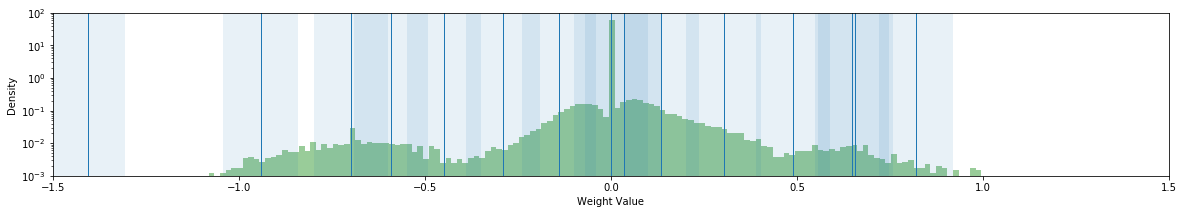

0-component Mean: 100.0 Variance: 999.9999999999998
Non-zero component Mean: 100.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.45, Prune Accuracy: 98.02, Sparsity: 65.02
Epoch: 20. Test Accuracy: 98.25, Prune Accuracy: 95.53, Sparsity: 84.82
Epoch: 30. Test Accuracy: 98.26, Prune Accuracy: 97.95, Sparsity: 68.50
Epoch: 40. Test Accuracy: 98.28, Prune Accuracy: 97.92, Sparsity: 94.67
Epoch: 50. Test Accuracy: 98.37, Prune Accuracy: 97.94, Sparsity: 94.68
Retrain Test: 98.37, Prune Test: 97.94, Prune Sparsity: 94.68


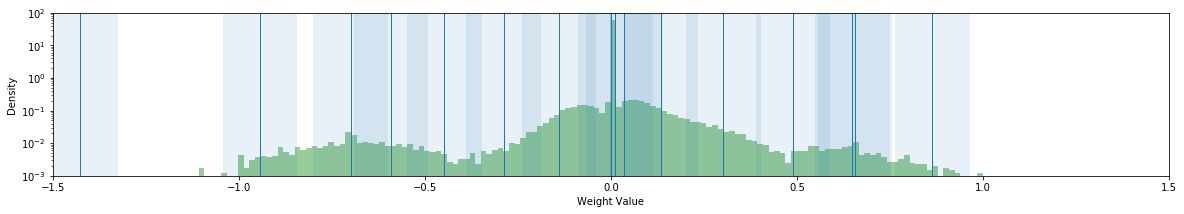

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 100.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.37, Prune Accuracy: 97.89, Sparsity: 65.34
Epoch: 20. Test Accuracy: 98.28, Prune Accuracy: 95.52, Sparsity: 84.41
Epoch: 30. Test Accuracy: 98.14, Prune Accuracy: 97.84, Sparsity: 84.59
Epoch: 40. Test Accuracy: 98.18, Prune Accuracy: 98.03, Sparsity: 83.70
Epoch: 50. Test Accuracy: 98.20, Prune Accuracy: 97.98, Sparsity: 81.23
Retrain Test: 98.20, Prune Test: 97.98, Prune Sparsity: 81.23


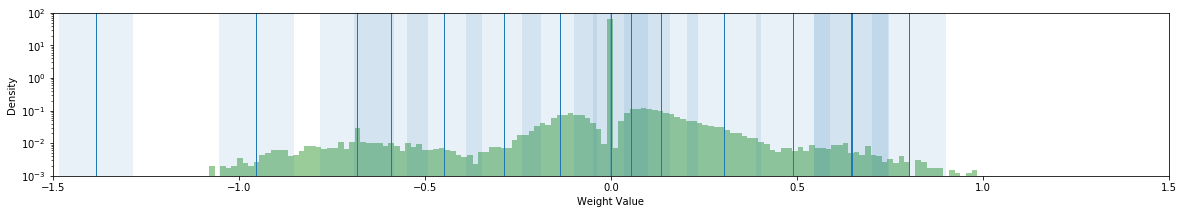

0-component Mean: 10.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.31, Prune Accuracy: 98.07, Sparsity: 65.48
Epoch: 20. Test Accuracy: 98.25, Prune Accuracy: 95.27, Sparsity: 77.50
Epoch: 30. Test Accuracy: 98.09, Prune Accuracy: 97.08, Sparsity: 95.06
Epoch: 40. Test Accuracy: 98.27, Prune Accuracy: 97.35, Sparsity: 95.14
Epoch: 50. Test Accuracy: 98.21, Prune Accuracy: 97.29, Sparsity: 95.24
Retrain Test: 98.21, Prune Test: 97.29, Prune Sparsity: 95.24


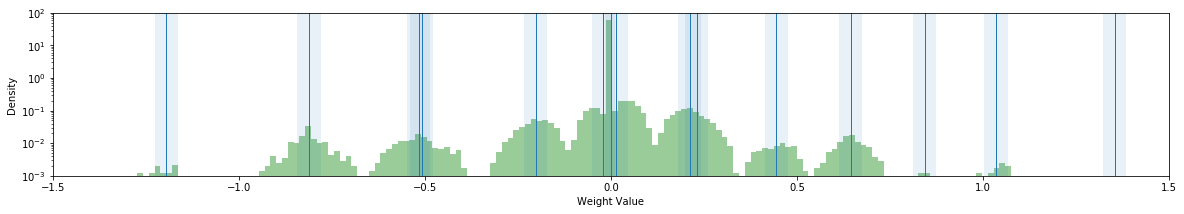

0-component Mean: 100.0 Variance: 999.9999999999998
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.37, Prune Accuracy: 98.09, Sparsity: 65.54
Epoch: 20. Test Accuracy: 98.25, Prune Accuracy: 95.41, Sparsity: 74.91
Epoch: 30. Test Accuracy: 98.03, Prune Accuracy: 96.84, Sparsity: 95.28
Epoch: 40. Test Accuracy: 98.29, Prune Accuracy: 97.44, Sparsity: 95.35
Epoch: 50. Test Accuracy: 98.23, Prune Accuracy: 97.50, Sparsity: 95.44
Retrain Test: 98.23, Prune Test: 97.50, Prune Sparsity: 95.44


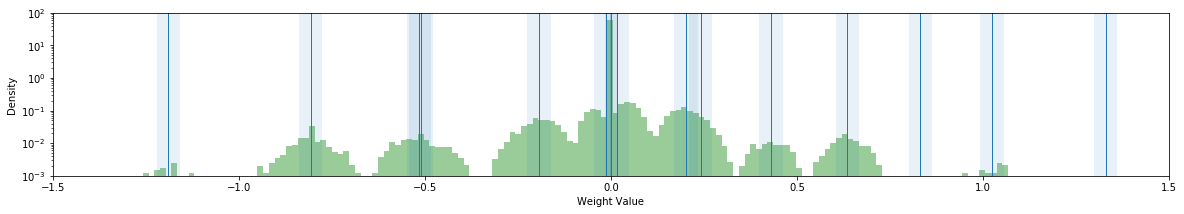

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.45, Prune Accuracy: 97.99, Sparsity: 65.73
Epoch: 20. Test Accuracy: 98.27, Prune Accuracy: 95.47, Sparsity: 83.17
Epoch: 30. Test Accuracy: 97.62, Prune Accuracy: 96.81, Sparsity: 97.33
Epoch: 40. Test Accuracy: 97.89, Prune Accuracy: 97.22, Sparsity: 97.30
Epoch: 50. Test Accuracy: 97.96, Prune Accuracy: 97.34, Sparsity: 97.30
Retrain Test: 97.96, Prune Test: 97.34, Prune Sparsity: 97.30


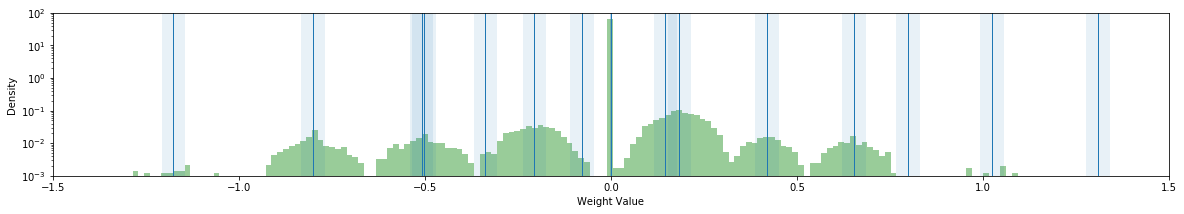

In [5]:
var = 0.1
zvar = 1000
mlist = [0.1, 1, 10, 100, 1000]
zmlist = [10, 100, 1000]
for mean in mlist:
    for zmean in zmlist:
        model, gmp, res = retrain_model(mean, var, zmean, zvar, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files")
        show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 0.1 Variance: 0.1
Epoch: 10. Test Accuracy: 98.39, Prune Accuracy: 97.68, Sparsity: 81.29
Epoch: 20. Test Accuracy: 98.14, Prune Accuracy: 97.26, Sparsity: 96.34
Epoch: 30. Test Accuracy: 98.13, Prune Accuracy: 97.74, Sparsity: 96.34
Epoch: 40. Test Accuracy: 98.11, Prune Accuracy: 97.87, Sparsity: 94.30
Epoch: 50. Test Accuracy: 98.20, Prune Accuracy: 97.71, Sparsity: 94.79
Retrain Test: 98.20, Prune Test: 97.71, Prune Sparsity: 94.79


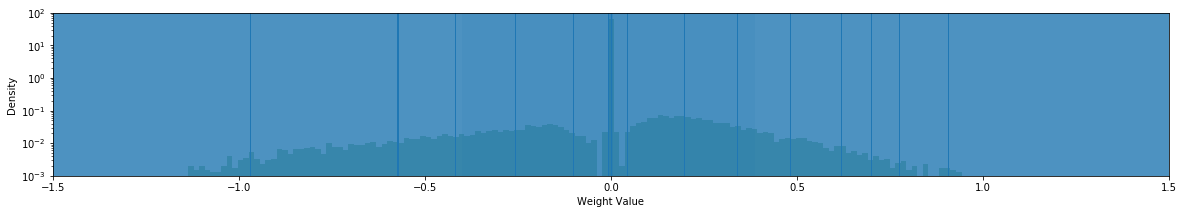

0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.38, Prune Accuracy: 97.97, Sparsity: 81.91
Epoch: 20. Test Accuracy: 98.07, Prune Accuracy: 97.23, Sparsity: 96.33
Epoch: 30. Test Accuracy: 98.13, Prune Accuracy: 97.74, Sparsity: 84.77
Epoch: 40. Test Accuracy: 98.18, Prune Accuracy: 97.91, Sparsity: 83.22
Epoch: 50. Test Accuracy: 98.30, Prune Accuracy: 97.84, Sparsity: 86.36
Retrain Test: 98.30, Prune Test: 97.84, Prune Sparsity: 86.36


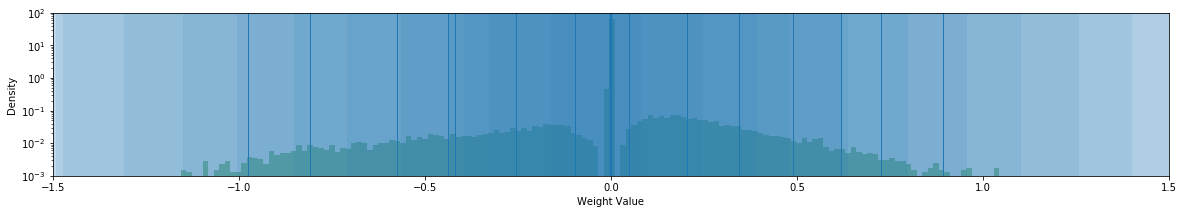

0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 10.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.36, Prune Accuracy: 97.19, Sparsity: 80.92
Epoch: 20. Test Accuracy: 98.02, Prune Accuracy: 97.57, Sparsity: 96.24
Epoch: 30. Test Accuracy: 98.18, Prune Accuracy: 97.91, Sparsity: 96.22
Epoch: 40. Test Accuracy: 98.15, Prune Accuracy: 97.97, Sparsity: 93.12
Epoch: 50. Test Accuracy: 98.15, Prune Accuracy: 97.74, Sparsity: 93.94
Retrain Test: 98.15, Prune Test: 97.74, Prune Sparsity: 93.94


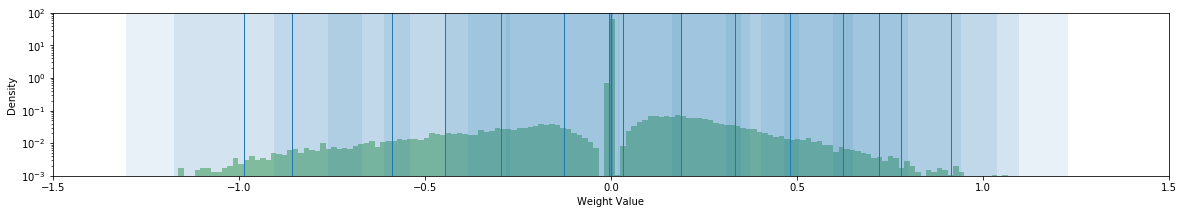

0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 100.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.43, Prune Accuracy: 97.94, Sparsity: 70.83
Epoch: 20. Test Accuracy: 97.94, Prune Accuracy: 97.41, Sparsity: 92.23
Epoch: 30. Test Accuracy: 98.08, Prune Accuracy: 97.82, Sparsity: 94.04
Epoch: 40. Test Accuracy: 98.07, Prune Accuracy: 97.46, Sparsity: 97.12
Epoch: 50. Test Accuracy: 98.21, Prune Accuracy: 97.57, Sparsity: 97.11
Retrain Test: 98.21, Prune Test: 97.57, Prune Sparsity: 97.11


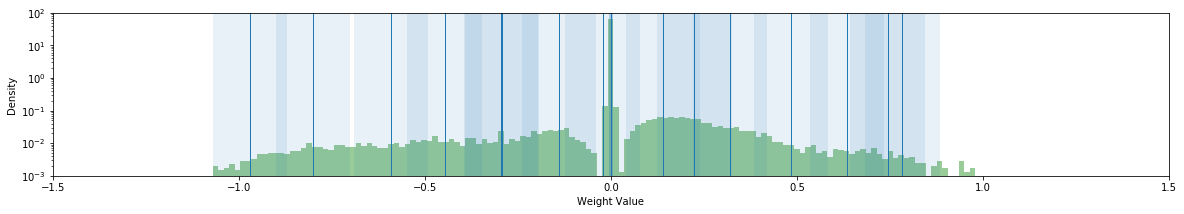

0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.33, Prune Accuracy: 97.88, Sparsity: 69.10
Epoch: 20. Test Accuracy: 98.00, Prune Accuracy: 95.54, Sparsity: 94.12
Epoch: 30. Test Accuracy: 98.14, Prune Accuracy: 97.12, Sparsity: 96.90
Epoch: 40. Test Accuracy: 98.13, Prune Accuracy: 97.48, Sparsity: 96.90
Epoch: 50. Test Accuracy: 98.26, Prune Accuracy: 97.66, Sparsity: 96.91
Retrain Test: 98.26, Prune Test: 97.66, Prune Sparsity: 96.91


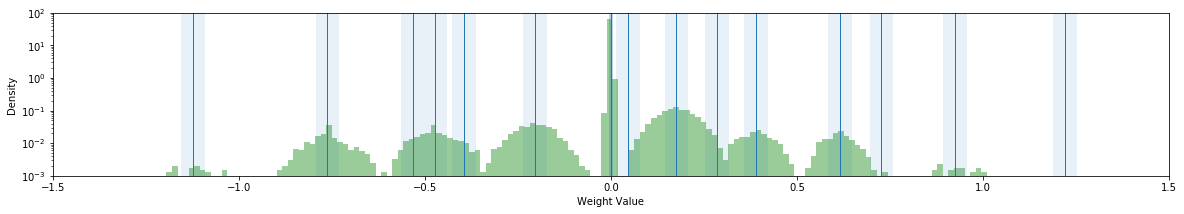

In [6]:
var = 0.1
zvar = 1000
mlist = [0.1, 1, 10, 100, 1000]
zmlist = [5000]
for mean in mlist:
    for zmean in zmlist:
        model, gmp, res = retrain_model(mean, var, zmean, zvar, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files")
        show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### 4 Temp v Tau

In [7]:
temp_list = [1, 2, 4, 5, 6, 8]
tau_list = [5e-5, 2e-5, 1e-5, 5e-6, 2e-6, 1e-6]
for temp in temp_list:
    for tau in tau_list:
        if (temp == 5 and tau == 1e-5): #skip
            print ("skip")
        else:
            model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, tau, temp, 16, "LeNet_300_100", "full", 'CEST', False, "./files")

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 86.31, Prune Accuracy: 10.51, Sparsity: 99.62
Epoch: 20. Test Accuracy: 88.45, Prune Accuracy: 16.77, Sparsity: 99.62
Epoch: 30. Test Accuracy: 88.68, Prune Accuracy: 10.62, Sparsity: 99.62
Epoch: 40. Test Accuracy: 89.23, Prune Accuracy: 16.33, Sparsity: 99.62
Epoch: 50. Test Accuracy: 89.31, Prune Accuracy: 16.25, Sparsity: 99.62
Retrain Test: 89.31, Prune Test: 16.25, Prune Sparsity: 99.62
0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 92.13, Prune Accuracy: 24.48, Sparsity: 99.51
Epoch: 20. Test Accuracy: 92.64, Prune Accuracy: 27.02, Sparsity: 99.52
Epoch: 30. Test Accuracy: 92.80, Prune Accuracy: 26.26, Sparsity: 99.52
Epoch: 40. Test Accuracy: 93.06, Prune Accuracy: 28.47, Sparsity: 99.52
Epoch: 50. Test Accuracy: 93.18, Prune Accuracy: 30.65, Sparsity: 99.52
Retrain Test: 93.18, Prune Test: 30.65, Pr

KeyboardInterrupt: 

> /anaconda/envs/py35/lib/python3.5/site-packages/torch/functional.py(64)stack()
     62     inputs = [t.unsqueeze(dim) for t in sequence]
     63     if out is None:
---> 64         return torch.cat(inputs, dim)
     65     else:
     66         return torch.cat(inputs, dim, out=out)

ipdb> exit
